<h2>Question 4</h2>
Read and display each image of the video, and print the frame number on the displayed image.
Write a program that finds the five CCCs in each image, and marks each one with a cross hair or rectangle.
Create an output video of your results and post it on YouTube.

<h3>Solution</h3>
I started by taking the first frame of the video and thresholding the image using HSV thresholds. The image is then checked for the outer circle components and the inverse for the inner cicle components. If the inner was inside the outer and centers of the circles were within a threshold of 3px (only needs to be 1px though). For each match, I created a CCC class object. The object stores the previous position, and last position, area, last area, and the stats gathered from the components. Each is also initialized with a color (For EXTRA CREDIT) instead of a number to draw.

After the CCCs are created, the video repeats the image processing done to the first frame for all the rest. In the following loop for the rest of the video, after identifying two centroids that are close together, this is pasted to the CCC compare function that checks to see if it fits the thresholds of the previous size and position. If it matches, the attributes are updated and a box is drawn by call the drawBoundingBox method. The method gets the information of where to draw from the object stats that were just updated. The CCC's bounding box is drawn in the previous position if the position isn't updated (e.g. doesn't fit the thresholds). Finally, a video writer saves the frame.

In [33]:
import cv2
import time
import PIL.Image
from io import BytesIO
import IPython.display
import ipywidgets as widgets
import numpy as np

#Use 'jpeg' instead of 'png' (~5 times faster)
def array_to_image(a, fmt='jpeg'):
    #Create binary stream object
    f = BytesIO()
    #Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)
    return IPython.display.Image(data=f.getvalue(), width=400)
    
def color_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

def nothing(x):
    pass

def initializeCCCs():
    try:
        original_img = cv2.imread('frame1.jpg')
        thresh_img = processFrame(original_img)
        colors = [(0,0,255), (255,0,0), (0,255,0), (255, 255, 0), (0, 255,255)]
    finally:
        kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
        kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
        kernelDilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
        kernelErode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

        innerComponents = cv2.dilate(cv2.erode(~thresh_img, kernelErode),kernelDilate)

        filtered_img_close = cv2.morphologyEx(thresh_img, cv2.MORPH_CLOSE, kernelClose)
        filtered_img_open = cv2.morphologyEx(filtered_img_close, cv2.MORPH_OPEN, kernelOpen,10)
        outerComponents = filtered_img_open

        num_labels_inner, labels_im_inner, innerStats, innerCentroids = cv2.connectedComponentsWithStats(innerComponents, connectivity=8)
        color_labeled_img_inner = color_components(labels_im_inner)
        d1.update(array_to_image(color_labeled_img_inner))

        num_labels_outer, labels_im_outer, outerStats, outerCentroids = cv2.connectedComponentsWithStats(outerComponents, connectivity=8)
        color_labeled_img_outer = color_components(labels_im_outer)
        d2.update(array_to_image(color_labeled_img_outer))

        CCCs = []
        ccc_counter = 0
        for i, i_centroid in enumerate(innerCentroids):
            if (i == 0):
                continue
            for j, o_centroid in enumerate(outerCentroids):
                if (j == 0):
                    continue
                xi = int(i_centroid[0])
                yi = int(i_centroid[1])
                xo = int(o_centroid[0])
                yo = int(o_centroid[1])
                if(np.abs(xi - xo) < 3):
                    if(np.abs(yi - yo) < 3):
                        ccc_counter += 1
                        ccc = CCC(str(ccc_counter), xi, yi, xo, yo, outerStats[j],colors[ccc_counter-1])
                        original_img = ccc.drawBoundingBox(original_img)
                        CCCs.append(ccc)
                    
    return CCCs

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def processFrame(original_img):
    low_thresholds = [0, 0, 0]
    high_thresholds = [255, 255, 150]
    
    image_height = original_img.shape[0] 
    image_width = original_img.shape[1]
    
    # Convert BGR to HSV.
    hsv_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)# Split into the different bands.
    planes = cv2.split(hsv_img)
    
    # Create output thresholded image.
    thresh_img = np.full((image_height, image_width), 255, dtype=np.uint8)
    
    for i in range(3):      
        _,low_img = cv2.threshold(planes[i], low_thresholds[i], 255, cv2.THRESH_BINARY)            
        _,high_img = cv2.threshold(planes[i], high_thresholds[i], 255, cv2.THRESH_BINARY_INV)            
        thresh_band_img = cv2.bitwise_and(low_img, high_img)            
        thresh_img = cv2.bitwise_and(thresh_img, thresh_band_img)
        
    return thresh_img

class CCC:
    def __init__(self, name, x_inner, y_inner, x_outer, y_outer, stats, color):
        self.name = name
        self.x_inner = x_inner
        self.y_inner = y_inner
        self.previous_x_inner = x_inner
        self.previous_y_inner = y_inner
        self.x_outer = x_outer
        self.y_outer = y_outer
        self.previous_x_outer = x_outer
        self.previous_y_outer = y_outer
        self.stats = stats
        self.area = stats[4]
        self.previous_area = stats[4]
        self.color = color
        self.updated = False
    
    def compare(self, xi, yi, xo, yo, area):
        if (np.abs(self.x_inner-xi) > 10):
            return False
        if (np.abs(self.x_outer-xo) > 10):
            return False
        if (np.abs(self.y_inner - yi) > 10):
            return False
        if (np.abs(self.y_outer - yo) > 10):
            return False
        if (np.abs(self.area - area) > 150):
            return False
        return True
    
    def update(self, x_inner, y_inner, x_outer, y_outer, stats):
        self.previous_x_inner = self.x_inner
        self.previous_y_inner = self.y_inner
        self.previous_x_outer = self.x_outer
        self.previous_y_outer = self.y_outer
        self.previous_area = self.area
        self.x_inner = x_inner
        self.y_inner = y_inner
        
        self.x_outer = x_outer
        self.y_outer = y_outer

        
        try:
            self.stats = stats
            self.area = stats[4]
        except:
            pass
        self.updated = True
        
    def drawBoundingBox(self, img):
#     img = cv2.putText(img, text=str(self.name), org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#                     fontScale=1.5, color=(0, 255, 0))
        return cv2.rectangle(img=img, 
                             pt1=(self.stats[0], self.stats[1]), 
                             pt2=(self.stats[0]+self.stats[2], self.stats[1] + self.stats[3]), 
                             color=self.color, thickness=2)


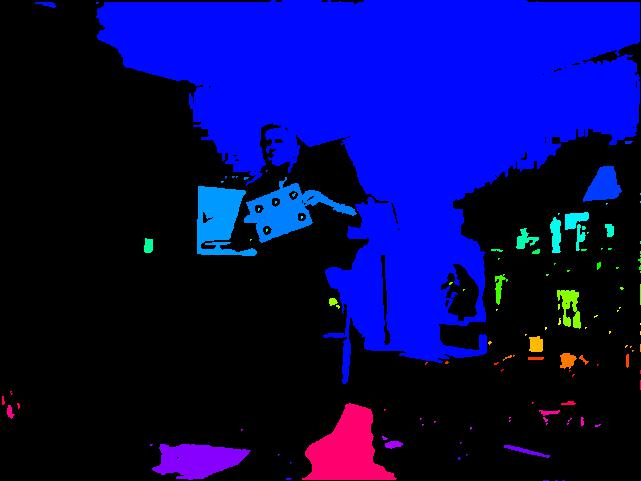

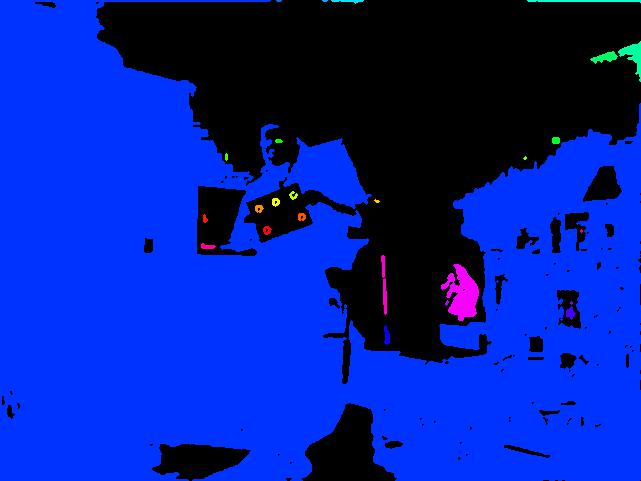

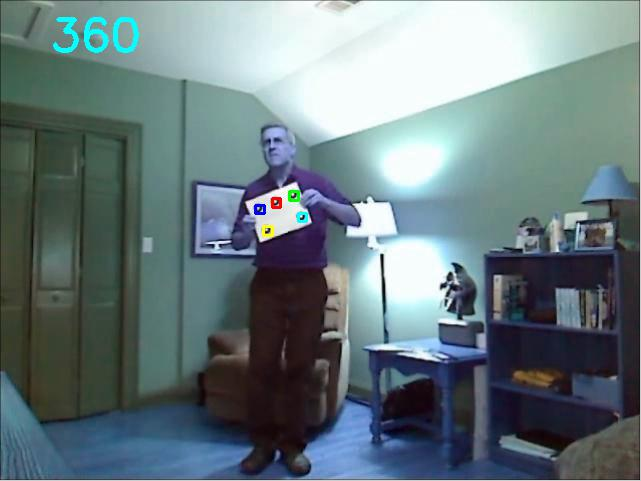

Output Video Saved
End of Video


In [34]:
d1 = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
d3 = IPython.display.display("", display_id=3)
try:
    video_name = "fiveCCC.avi"
    cam = cv2.VideoCapture(video_name)

    fps = 30
    frame = 0
    total_frames = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))


    # Create output movie file.
    video_output_name = video_name[0:video_name.find(".")]+"_output"+".avi"
    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    videoWriter = cv2.VideoWriter(apiPreference=cv2.CAP_FFMPEG, filename=video_output_name, fourcc=fourcc, fps=30,
                                  frameSize=(int(cam.get(3)), int(cam.get(4))))
    
    CCCs = initializeCCCs()
    while True:
        try:
            t1 = time.time()
            # Try to read in video
            got_image, original_img = cam.read()
            if not got_image:
                break # break if no video
            frame += 1
            
            for ccc in CCCs:
                ccc.updated = False


            thresh_img = processFrame(original_img)
            kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
            kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
            kernelDilate = cv2.getStructuringElement(cv2.MORPH_CROSS, (2, 2))
            kernelErode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

            innerComponents = cv2.dilate(cv2.erode(~thresh_img, kernelErode),kernelDilate)

            filtered_img_close = cv2.morphologyEx(thresh_img, cv2.MORPH_CLOSE, kernelClose)
            filtered_img_open = cv2.morphologyEx(filtered_img_close, cv2.MORPH_OPEN, kernelOpen,10)
            outerComponents = filtered_img_open

            num_labels_inner, labels_im_inner, innerStats, innerCentroids = cv2.connectedComponentsWithStats(innerComponents, connectivity=8)
            color_labeled_img_inner = color_components(labels_im_inner)
            d1.update(array_to_image(color_labeled_img_inner))

            num_labels_outer, labels_im_outer, outerStats, outerCentroids = cv2.connectedComponentsWithStats(outerComponents, connectivity=8)
            color_labeled_img_outer = color_components(labels_im_outer)
            d2.update(array_to_image(color_labeled_img_outer))
            
            not_updated = []
            
            for i, i_centroid in enumerate(innerCentroids):
                if (i == 0):
                    continue
                for j, o_centroid in enumerate(outerCentroids):
                    if (j == 0):
                        continue
                    xi = int(i_centroid[0])
                    yi = int(i_centroid[1])
                    xo = int(o_centroid[0])
                    yo = int(o_centroid[1])
                    if(np.abs(xi - xo) < 3):
                        if(np.abs(yi - yo) < 3):
                            not_updated.append([[xi],[yi],[xo],[yo]])
                            for ccc in CCCs:
                                if (ccc.compare(xi, yi, xo, yo, outerStats[j][4])):
                                    ccc.update(xi, yi, xo, yo, outerStats[j])
                                    original_img = ccc.drawBoundingBox(original_img)
                                    break
                            else:
                                not_updated.pop()
            
            for ccc in CCCs: 
                if (not ccc.updated):
                    ccc.drawBoundingBox(original_img)
        
            original_img = cv2.putText(original_img, text=str(frame), org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1.5, color=(0, 255, 255), thickness=3)

            videoWriter.write(original_img)

            # Jupyter Video output display
#             thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2RGB)
            while time.time() < t1 + (1/(fps+ 1)):
                continue
            t2 = time.time()
            
            s = f"""<h1>{int(1/(t2-t1))} FPS</h1>"""
#                 d3.update( IPython.display.HTML(s) )
            d3.update(array_to_image(original_img))
            
        except KeyboardInterrupt:
            print ("Stream stopped by Keyboard")
            break

finally:
    cam.release()
    videoWriter.release()
    cv2.destroyAllWindows()
    print("Output Video Saved")
    print("End of Video")
    
    